In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import datetime
from datetime import timedelta
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (30, 15)
# mpl.rcParams['axes.grid'] = False

target="close"

In [3]:
def getDataset(full=False):
    url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
    df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
    # df.drop(columns=['open', 'high', 'low'], inplace=True)
    pdlen=len(df)
    
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    # df.set_axis(df['date'], inplace=True)
    # df.drop(columns=["volume"], inplace=True)
    df.drop(columns=["volume", "low", "open", "high"], inplace=True)
    # df["Close"]= df["close"] # compatibility
    # df["Volume"]= df["volume"] # compatibility
    # df.drop(columns=['close'], inplace=True)
    # df["ewma_close"]=df["close"].ewm(4).mean()
    if full is False:
        df=df[58::60]
        
    return df

In [4]:
df = getDataset(full=False)

# df.set_axis(df['date'])[target].plot(figsize=(15,8))
# plt.legend(["close"])
# plt.grid(True)
# plt.title("Wykres przedstawiający wartość stosunku ceny euro do dolara amerykańskiego w roku 2018")
# plt.xlabel("Data")
# plt.ylabel("Wartość stosunku euro do dolara")

In [5]:
df.describe()

,close
count,6210.000000
mean,1.181210
std,0.036874
min,1.121820
25%,1.152335
50%,1.169185
75%,1.223935
max,1.254480


In [6]:
date_time = pd.to_datetime(df.pop('date'))
print(date_time)

58       2018-01-01 17:59:00
118      2018-01-01 18:59:00
178      2018-01-01 19:59:00
238      2018-01-01 20:59:00
298      2018-01-01 21:59:00
                 ...        
372358   2018-12-31 12:51:00
372418   2018-12-31 13:51:00
372478   2018-12-31 14:51:00
372538   2018-12-31 15:51:00
372598   2018-12-31 16:51:00
Name: date, Length: 6210, dtype: datetime64[ns]


In [7]:
# adjusted_date_time = []
# print([date_time.values[0]+timedelta(minutes=(i-1)*1) for i in range(len(date_time.values))])


date_time_clone = date_time.copy()
new_values=pd.date_range(date_time.values[0], periods=len(date_time), freq='1h')

i=0
for key in date_time_clone.copy().keys():
    date_time_clone[key]=new_values[i]
    i=i+1

date_time=date_time_clone
print(date_time)

58       2018-01-01 17:59:00
118      2018-01-01 18:59:00
178      2018-01-01 19:59:00
238      2018-01-01 20:59:00
298      2018-01-01 21:59:00
                 ...        
372358   2018-09-17 06:59:00
372418   2018-09-17 07:59:00
372478   2018-09-17 08:59:00
372538   2018-09-17 09:59:00
372598   2018-09-17 10:59:00
Name: date, Length: 6210, dtype: datetime64[ns]


In [8]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

timestamp_s[:5]

58     1.514826e+09
118    1.514830e+09
178    1.514833e+09
238    1.514837e+09
298    1.514840e+09
Name: date, dtype: float64

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
# train_df.describe()
test_df

,close,Day sin,Day cos,Year sin,Year cos
335398,1.13617,-0.254602,-0.967046,-0.772109,-0.635490
335458,1.13478,-0.496217,-0.868199,-0.772565,-0.634936
335518,1.13545,-0.704015,-0.710185,-0.773020,-0.634382
335578,1.13447,-0.863836,-0.503774,-0.773474,-0.633828
335638,1.13481,-0.964787,-0.263031,-0.773928,-0.633273
...,...,...,...,...,...
372358,1.14462,0.964787,0.263031,-0.969625,-0.244598
372418,1.14454,0.999990,0.004363,-0.969800,-0.243903
372478,1.14529,0.967046,-0.254602,-0.969974,-0.243207
372538,1.14596,0.868199,-0.496217,-0.970148,-0.242512


In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [13]:
def plotLossHistory(history, figsize=(30,15)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(history.history['loss'], label='Wartość funkcji kosztu dla zbioru treningowego')
    ax.plot(history.history['val_loss'], label='Wartość funkcji kosztu dla zbioru walidacyjnego')
    plt.ylabel('Wartość funkcji kosztu')
    plt.xlabel('Numer epoki')
    ax.legend(loc="upper left")
    plt.title("Wartość funkcji kosztu na przestrzeni epok")
    plt.show()

In [14]:
def plotMAEHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['mean_absolute_error'], label='MAE podczas treningu')
    ax.plot(history.history['val_mean_absolute_error'], label='MAE na zbiorze walidacyjnym')
    plt.ylabel('MAE value')
    plt.xlabel('Numer epoki')
    ax.legend(loc="upper left")
    plt.show()

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col=target, max_subplots=3, title=None, figsize=(12,8)):
  inputs, labels = self.example
  plt.figure(figsize=figsize)
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)

    if title is not None and n==0:
      plt.title(title)

    plt.xticks(np.arange(0, 48, step=1))
    # plt.xticks(np.arange(0, len(self.input_indices)+1, step=1))
    
    plt.ylabel(f'{plot_col} [znormalizowana wartość]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Wejście', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Prawdziwe wartości', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      # print(predictions)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predykcje',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Czas od pierwszej próbki [h]')

WindowGenerator.plot = plot

In [17]:
# w2.plot()

In [18]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[target])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [21]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [22]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [23]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[target])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [24]:
# print('Input shape:', single_step_window.example[0].shape)
# print('Output shape:', linear(single_step_window.example[0]).shape)

In [25]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=5, max_epochs=MAX_EPOCHS):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [26]:
mpl.rcParams['figure.figsize'] = (20, 10)

In [30]:
import time

multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

val_performance_single={}
performance_single={}
def exper(n=10):
    start = time.time()

    print(f"n={n}")

    rnn_model = ResidualWrapper(tf.keras.Sequential([
        tf.keras.layers.LSTM(n, return_sequences=True),
        tf.keras.layers.LSTM(n, return_sequences=True),
        # tf.keras.layers.LSTM(n, return_sequences=True),
        # tf.keras.layers.LSTM(n, return_sequences=True),
        # tf.keras.layers.LSTM(n, return_sequences=True),
        tf.keras.layers.Dense(num_features ,     kernel_initializer=tf.initializers.zeros),
    ]))

    history = compile_and_fit(rnn_model, multi_window, max_epochs=50, patience=50)

    IPython.display.clear_output()

    end = time.time()
    print("validation")
    val_performance_single['RNN'] = rnn_model.evaluate(multi_window.val, verbose=1)
    vali=val_performance_single['RNN']
    print("test")
    performance_single['RNN'] = rnn_model.evaluate(multi_window.test, verbose=1)
    testi=performance_single['RNN']

    ret = f"{n} & {end-start:0.3f} & {vali[0]:0.4f} & {vali[1]:0.4f} & {testi[0]:0.4f} & {testi[1]:0.4f} \\\\"

    return ret, rnn_model, history

# ret, model, history = exper(n=240)
# ret, model40, history = exper(n=40)


# print(ret)
# 20,30,40,50,60,80,120,240
#5,10,20,30,40,50,60,80,120 
# 240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240
xd = [exper(i)[0] for i in np.array([240,240,240,240,240,])]
print(xd)


# wide_window.plot(model)

n=40
Epoch 1/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0055 - mean_absolute_error: 0.0296 - val_loss: 0.0045 - val_mean_absolute_error: 0.0296
Epoch 2/50
122/135 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0278

KeyboardInterrupt: 

In [29]:
print(ret)

NameError: name 'ret' is not defined

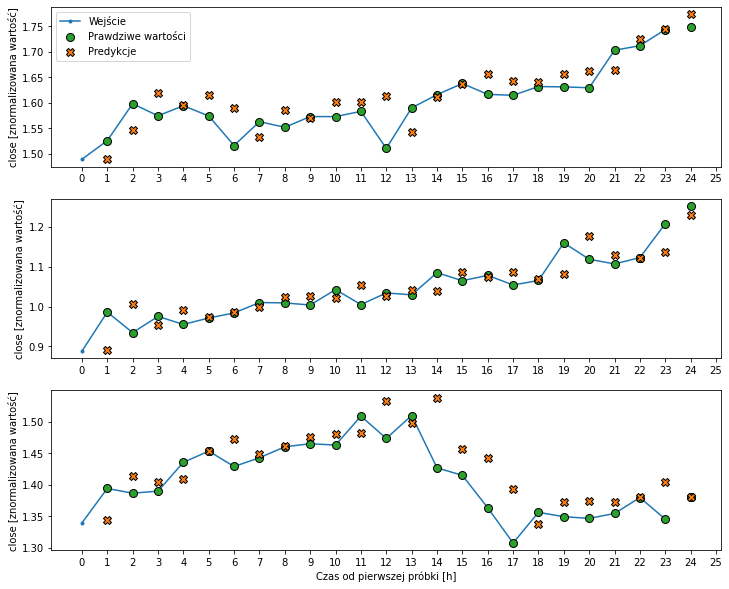

In [42]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[target])

wide_window.plot(model, figsize=(12,10))

In [31]:
def plotMany(self, model=None, plot_col=target, max_subplots=3, title=None, additionalModels=None):
  inputs, labels = self.example
  # plt.figure(figsize=(15, 15))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)

    if title is not None and n==0:
      plt.title(title)

    plt.xticks(np.arange(0, len(self.input_indices)+1, step=1))
    
    plt.ylabel(f'{plot_col} [znormalizowana wartość]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Wejście', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
 
    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Prawdziwe wartości', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
  
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predykcje',
                  c='#ff7f0e', s=64)
    if additionalModels is not None:
        for aModel in additionalModels:
            predictions = aModel(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], label='Predykcjee', s=64)       
    if n == 0:
      plt.legend()

  plt.xlabel('Czas od pierwszej próbki [h]')

WindowGenerator.plotMany = plotMany

In [32]:
# wide_window.plotMany(model20, additionalModels=np.array([model40]))

In [33]:
# plotLossHistory(history, figsize=(20,8))

In [34]:
# plotMAEHistory(history)

In [35]:
# for name, value in performance_single.items():
#   print(f'{name:12s}: {value[1]:0.4f}')

In [36]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [37]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

39/39 [==============================] - 0s 1ms/step - loss: 2.2029 - mean_absolute_error: 1.1002


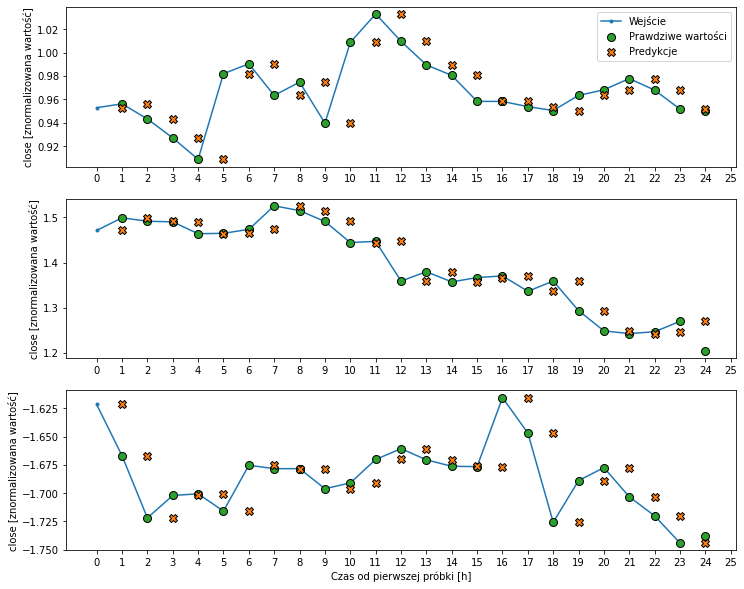

In [39]:
wide_window.plot(baseline, figsize=(12,10))

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

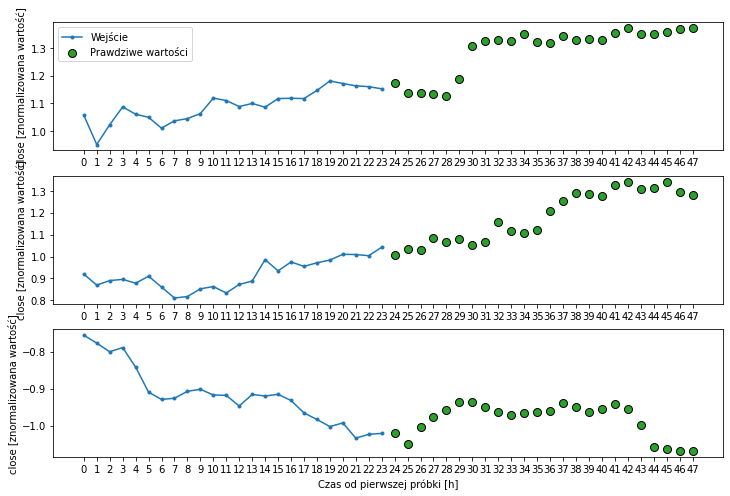

In [45]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(figsize=(12,8))
multi_window

18/18 [==============================] - 0s 1ms/step - loss: 0.8021 - mean_absolute_error: 0.4779


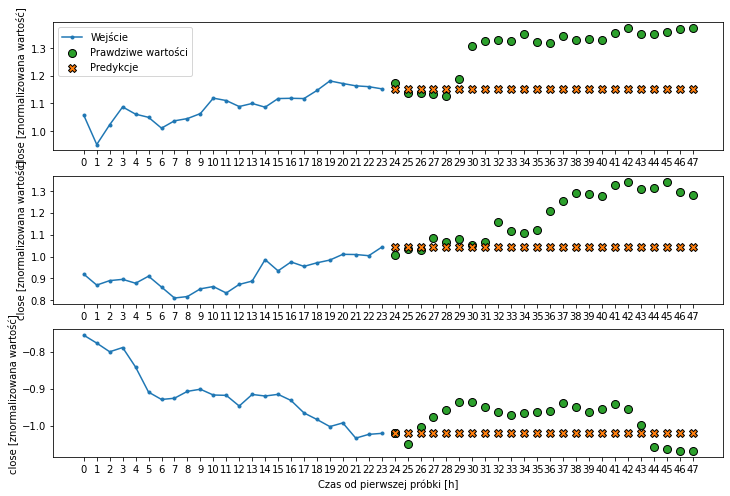

In [46]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test)
multi_window.plot(last_baseline, figsize=(12,8))

18/18 [==============================] - 0s 912us/step - loss: 0.0039 - mean_absolute_error: 0.0322


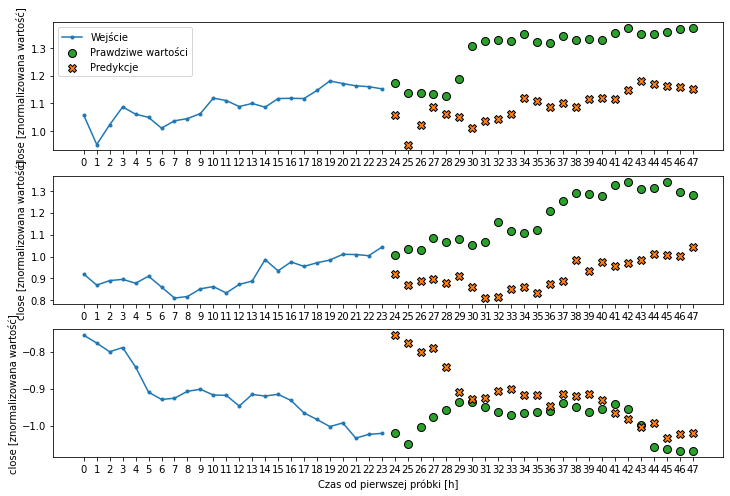

In [48]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)
multi_window.plot(repeat_baseline, figsize=(12,8))

38/38 [==============================] - 0s 3ms/step - loss: 0.5544 - mean_absolute_error: 0.5493


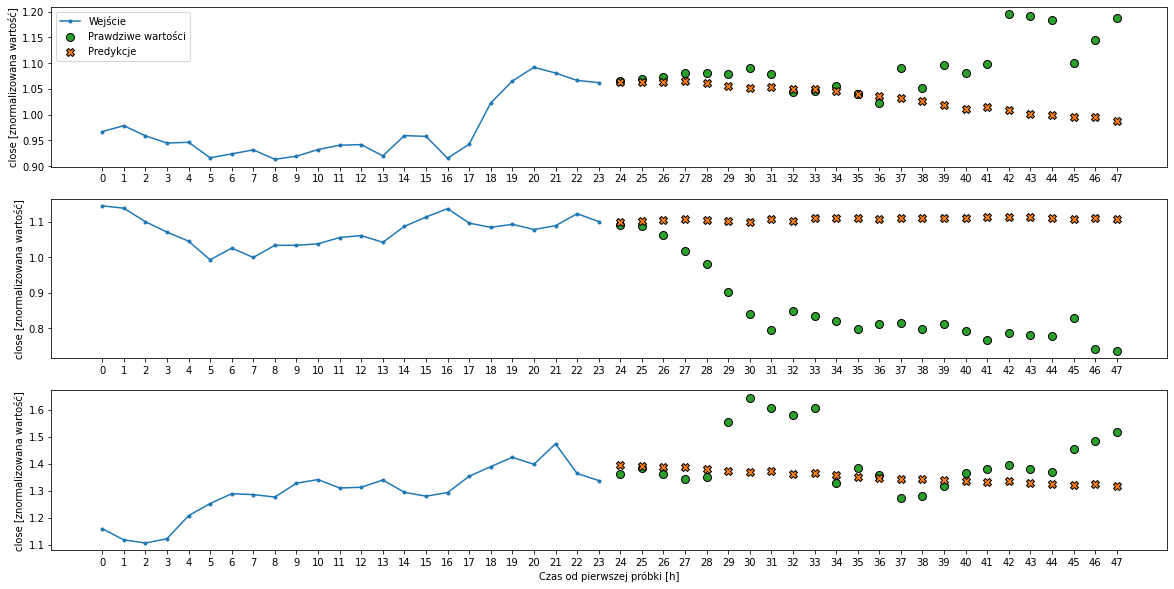

In [38]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(24, return_sequences=True),
    tf.keras.layers.LSTM(24, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)

38/38 [==============================] - 0s 4ms/step - loss: 0.1724 - mean_absolute_error: 0.3032


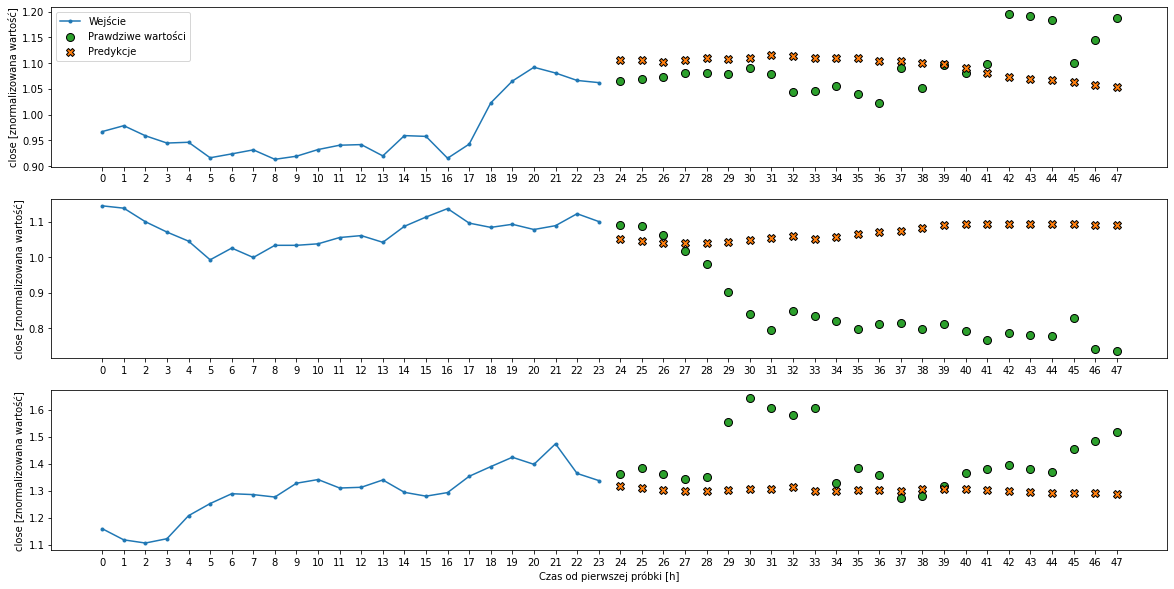

In [39]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(24, return_sequences=True),
    tf.keras.layers.GRU(24, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_gru_model, multi_window)

IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_gru_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_gru_model)

In [40]:
multi_gru_model.metrics_names

['loss', 'mean_absolute_error']

In [49]:
import time

val_performance_single={}
performance_single={}
def exper(n=10, layerType=tf.keras.layers.LSTM):
    start = time.time()

    print(f"n={n}")

    rnn_model = tf.keras.Sequential([
        # tf.keras.layers.GRU(n, return_sequences=True),
        # tf.keras.layers.LSTM(n, return_sequences=True),
        tf.keras.layers.GRU(n, return_sequences=True),
        tf.keras.layers.GRU(n, return_sequences=True),
        # tf.keras.layers.SimpleRNN(n, return_sequences=True),
        # tf.keras.layers.SimpleRNN(n, return_sequences=True),
        # tf.keras.layers.SimpleRNN(n, return_sequences=False),
        tf.keras.layers.Dense(1),
        # tf.keras.layers.Reshape([OUT_STEPS, 1])
    ])

    history = compile_and_fit(rnn_model, multi_window, max_epochs=50, patience=50)

    IPython.display.clear_output()

    end = time.time()
    print("validation")
    val_performance_single['RNN'] = rnn_model.evaluate(multi_window.val, verbose=1)
    vali=val_performance_single['RNN']
    print("test")
    performance_single['RNN'] = rnn_model.evaluate(multi_window.test, verbose=1)
    testi=performance_single['RNN']

    ret = f"{n} & {end-start:0.3f} & {vali[0]:0.4f} & {vali[1]:0.4f} & {testi[0]:0.4f} & {testi[1]:0.4f} \\\\"

    return ret, rnn_model, history

ret, model, history = exper(n=120)
# ret, model, history = exper(n=240)
print(ret)

# 20,30,40,50,60,80,120,240
#5,10,20,30,40,50,60,80,120 
# xd = [exper(i, layerType=tf.keras.layers.LSTM)[0] for i in np.array([80,120,240])]
# print(xd)

# xd2 = [exper(i, layerType=tf.keras.layers.GRU)[0] for i in np.array([5,10,20,30,40,50,60,80,120,240])]
# print(xd)


# multi_window.plot(model)

validation
38/38 [==============================] - 0s 5ms/step - loss: 2.0631 - mean_absolute_error: 1.0811
test
18/18 [==============================] - 0s 5ms/step - loss: 3.9315 - mean_absolute_error: 1.5279
120 & 139.498 & 2.0631 & 1.0811 & 3.9315 & 1.5279 \\


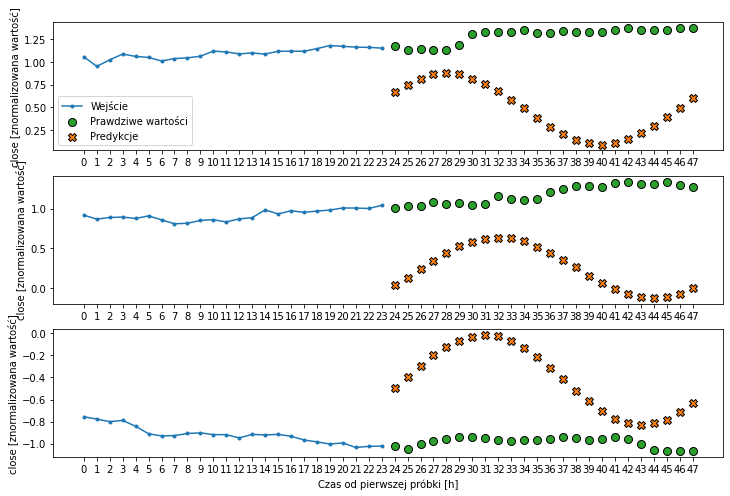

In [50]:
multi_window.plot(model, figsize=(12,8))

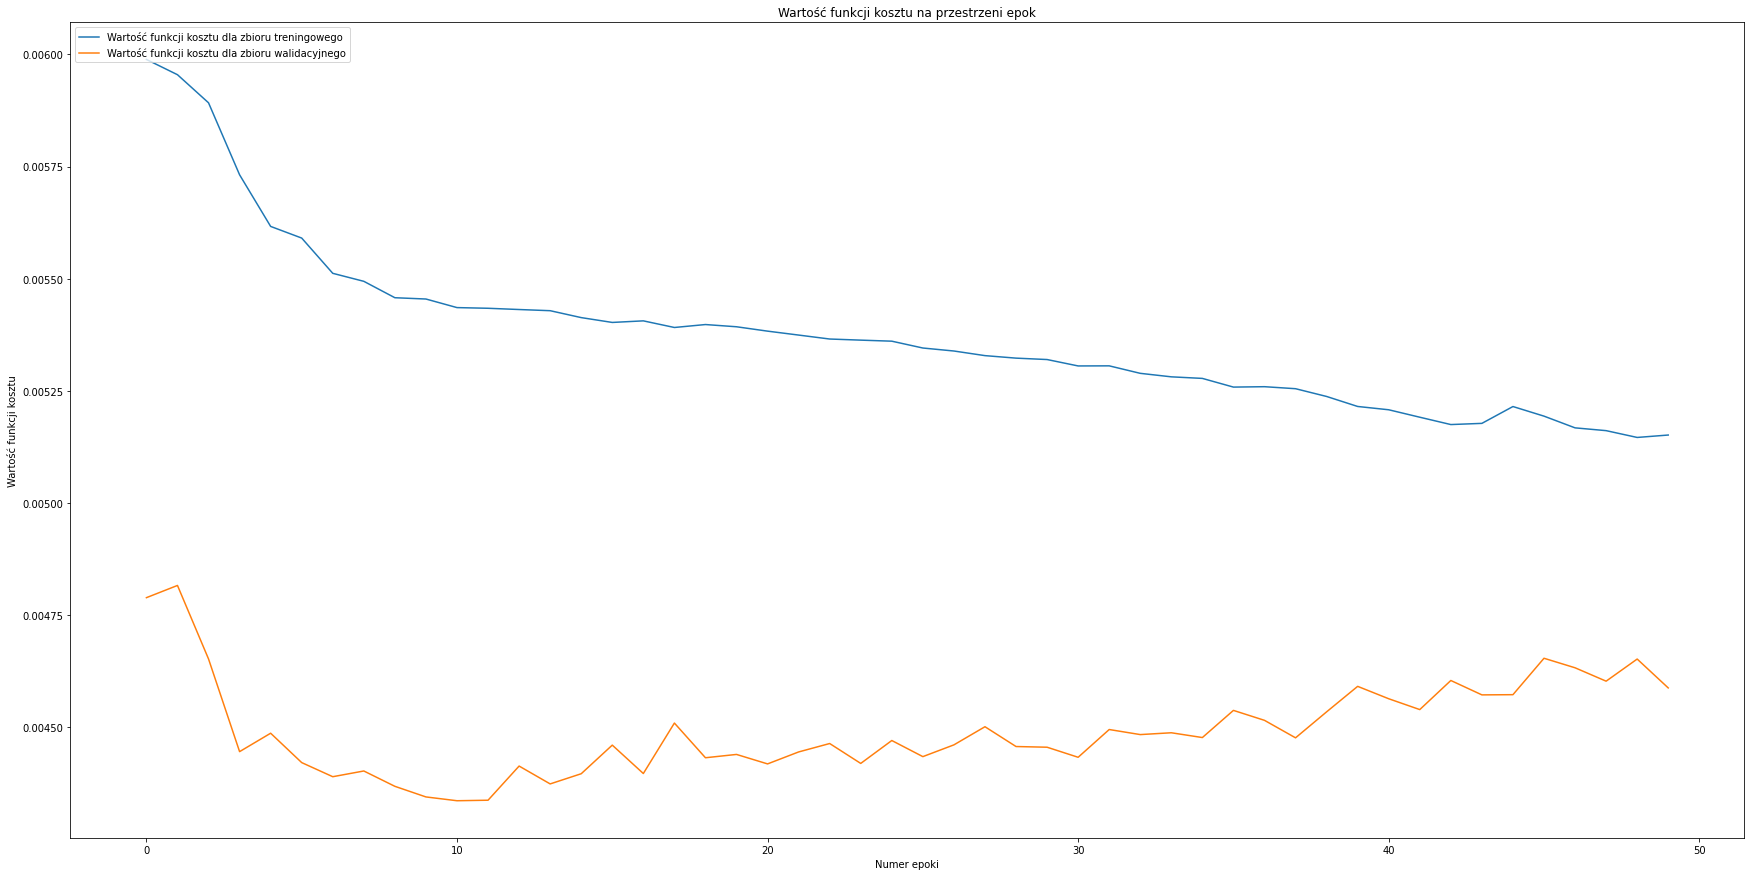

In [52]:
plotLossHistory(history)

In [40]:
print(xd)
print("\n")
# print(xd2)

['5 & 121.477 & 2.1009 & 1.0746 & 4.0184 & 1.4896 \\\\', '10 & 131.068 & 2.0985 & 1.0730 & 4.0413 & 1.4854 \\\\', '20 & 142.380 & 2.1127 & 1.0695 & 4.0963 & 1.4801 \\\\', '30 & 145.838 & 2.1054 & 1.0736 & 4.0608 & 1.4746 \\\\', '40 & 147.987 & 2.1180 & 1.0746 & 4.0889 & 1.4824 \\\\', '50 & 150.528 & 2.0819 & 1.0726 & 3.9853 & 1.4971 \\\\', '60 & 156.828 & 2.0919 & 1.0758 & 4.0082 & 1.4887 \\\\', '80 & 169.035 & 2.0705 & 1.0736 & 3.9530 & 1.5124 \\\\', '120 & 231.934 & 2.0729 & 1.0741 & 3.9640 & 1.5073 \\\\', '240 & 588.046 & 2.0673 & 1.0790 & 3.9387 & 1.5212 \\\\']


